# Projet Spochify 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

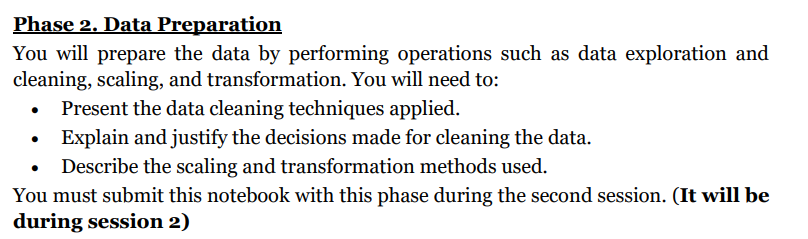

Pre-processing

Traitements fichier .csv

In [2]:
WINE_FILE_PATH = "Data/WineDataset.csv"
wine_df = pd.read_csv(WINE_FILE_PATH, header=0)
wine_df.head()

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [3]:
len(wine_df)

1290

In [11]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1279 non-null   object 
 1   Description                1276 non-null   object 
 2   Price                      1279 non-null   object 
 3   Capacity                   1279 non-null   object 
 4   Grape                      1271 non-null   object 
 5   Secondary Grape Varieties  1279 non-null   object 
 6   Closure                    1279 non-null   object 
 7   Country                    1279 non-null   object 
 8   Unit                       1276 non-null   float64
 9   Characteristics            1249 non-null   object 
 10  Per bottle / case / each   1279 non-null   object 
 11  Type                       1275 non-null   object 
 12  ABV                        1276 non-null   object 
 13  Region                     1120 non-null   objec

### Data Cleaning

#### 1. Price

In [4]:
wine_df["Per bottle / case / each"].unique()

array(['per bottle', 'per case', 'each'], dtype=object)

In [5]:
#remove non per bottle rows
wine_df = wine_df[~wine_df['Price'].str.contains(r'per case|each', case=False, na=False, regex=True)].reset_index(drop=True)
wine_df.head()

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [6]:
wine_df["Per bottle / case / each"].unique()

array(['per bottle'], dtype=object)

In [7]:
wine_df['Price_clean'] = (
    wine_df['Price']
    .str.replace('£', '', regex=False)
    .str.replace(' per bottle', '', regex=False)
    .astype(float)
)
wine_df.head()

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation,Price_clean
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN,9.99
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley,15.99
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN,12.49
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon,17.99
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley,15.99


#### 2. ABV

In [8]:
wine_df['ABV_clean'] = wine_df['ABV'].str.extract(r'(\d+\.\d+)').astype(float)
wine_df.head()


,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation,Price_clean,ABV_clean
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN,9.99,14.0
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley,15.99,13.5
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN,12.49,13.0
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon,17.99,13.5
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley,15.99,13.5


#### 4. Secondary Grape Varieties

In [9]:
wine_df["Secondary Grape Varieties"].unique()

array([nan, 'Touriga Nacional, Tinta Roriz', 'Pinot Noir, Pinot Meunier',
       'Assyrtiko, Roditis', 'Syrah, Grenache, Rolle', 'Syrah, Grenache',
       'Pinot Noir', 'Rolle, Cinsault', 'Pinot Meunier, Pinot Noir',
       'Pinot Meunier, Chardonnay, Pinot Blanc', 'Syrah, Cinsault',
       'Syrah, Carignan, Cinsault', 'Graciano',
       'Chardonnay, Pinot Meunier', 'Chardonnay, Pinot Blanc',
       'Pinot Meunier, Chardonnay',
       'Cinsault, Mourvèdre, Syrah, Vermentino', 'Tempranillo, Bobal',
       'Rivaner, Reichensteiner', 'Chardonnay',
       'Syrah, Cabernet Sauvignon, Cinsault',
       'Cabernet Sauvignon, Cabernet Franc, Carménère',
       'Cabernet Franc, Chardonnay', 'Merlot, Cabernet Sauvignon',
       'Merlot', 'Clairette, Grenache Blanc, Roussanne, Viognier',
       'Grenache, Graciano', 'Corvinone, Molinara, Rondinella',
       'Parellada, Xarel-lo', 'Cabernet Sauvignon',
       'Arinto, Trajadura, Avesso', 'Cinsault, Mourvèdre, Syrah',
       'Syrah, Carignan, Mourvè

In [10]:
wine_df['Secondary Grape Varieties'] = wine_df['Secondary Grape Varieties'].fillna("none")

#### 5. Drop NaN and useless columns

In [12]:
wine_df.dropna(axis=0, subset=['Country', 'Grape', 'Price_clean', 'ABV_clean'], inplace=True)

In [14]:
wine_df = wine_df.drop(columns=["Description", "ABV", "Price", "Unit", "Per bottle / case / each", "Appellation"])
wine_df.head()

,Title,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Characteristics,Type,Region,Style,Vintage,Price_clean,ABV_clean
0,"The Guv'nor, Spain",75CL,Tempranillo,none,Natural Cork,Spain,"Vanilla, Blackberry, Blackcurrant",Red,NaN,Rich & Juicy,NV,9.99,14.0
1,Bread & Butter 'Winemaker's Selection' Chardon...,75CL,Chardonnay,none,Natural Cork,USA,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",White,California,Rich & Toasty,2021,15.99,13.5
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",75CL,Sauvignon Blanc,none,Screwcap,New Zealand,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",White,Marlborough,Crisp & Zesty,2022,12.49,13.0
3,Louis Latour Mâcon-Lugny 2021/22,75CL,Chardonnay,none,Natural Cork,France,"Peach, Apricot, Floral, Lemon",White,Burgundy,Ripe & Rounded,2022,17.99,13.5
4,Bread & Butter 'Winemaker's Selection' Pinot N...,75CL,Pinot Noir,none,Natural Cork,USA,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",Red,California,Smooth & Mellow,2021,15.99,13.5


#### TODO

In [18]:
wine_df["Country"].unique()

array(['Spain', 'USA', 'New Zealand', 'France', 'Italy', 'Scotland',
       'Portugal', 'Greece', 'Australia', 'England', 'Argentina', 'Chile',
       'South Africa', 'Austria', nan, 'Lebanon', 'Germany', 'Serbia',
       'Moldova', 'Hungary', 'Slovenia', 'Romania', 'Georgia', 'Mexico',
       'United Kingdom', 'Bulgaria'], dtype=object)

In [15]:
len(wine_df[wine_df["Capacity"] == "Our"])

0

In [69]:
## Simple data frame => remove all columns sauf Pays + Alcool + Price for fisrt testing
# keep only the desired columns
ez_df = wine_df[['Price_clean', 'abv_value', 'Country', 'Grape']]
ez_df

,Price_clean,abv_value,Country,Grape
0,9.99,14.0,Spain,Tempranillo
1,15.99,13.5,USA,Chardonnay
2,12.49,13.0,New Zealand,Sauvignon Blanc
3,17.99,13.5,France,Chardonnay
4,15.99,13.5,USA,Pinot Noir
...,...,...,...,...
1274,11.99,12.5,France,Chenin Blanc
1275,13.99,13.0,New Zealand,Pinot Noir
1276,85.00,13.5,Australia,Cabernet Sauvignon
1277,37.99,14.5,Australia,Cabernet Sauvignon


In [ ]:
ez_df.shape

In [ ]:
# Import label encoder
# from sklearn import preprocessing

# encoder = preprocessing.LabelEncoder()
  
# # # Encode the Country (TO DO : lien entre les countries ??)
# ez_df['Country']= encoder.fit_transform(ez_df['Country'])
# ez_df

# # # Encode the Grape (TO DO : aucun lien entre les grapes)
# ez_df['Grape']= encoder.fit_transform(ez_df['Grape'])
# ez_df

C:\Users\USER\AppData\Local\Temp\ipykernel_8088\2395896416.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ez_df['Country']= encoder.fit_transform(ez_df['Country'])
C:\Users\USER\AppData\Local\Temp\ipykernel_8088\2395896416.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ez_df['Grape']= encoder.fit_transform(ez_df['Grape'])


,Price_clean,abv_value,Country,Grape
0,9.99,14.0,20,93
1,15.99,13.5,21,16
2,12.49,13.0,14,86
3,17.99,13.5,6,16
4,15.99,13.5,21,75
...,...,...,...,...
1274,11.99,12.5,6,17
1275,13.99,13.0,14,75
1276,85.00,13.5,1,12
1277,37.99,14.5,1,12


In [70]:
# If ID isn't useful, you can drop it
X = ez_df[['abv_value', 'Country', 'Grape']]
y = ez_df['Price_clean']

In [71]:
categorical_features = ['Country', 'Grape']
numeric_features = ['abv_value']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)



In [72]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
pipeline.fit(X_train, y_train)

c:\Users\USER\miniconda3\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Country', 'Grape'])])),
                ('regressor', LinearRegression())])

In [ ]:
score = pipeline.score(X_test, y_test)
print(f"Test R^2 Score: {score:.2f}")

# Predict some values
y_pred = pipeline.predict(X_test)
print(X_test)
print("Predictions for test set:", y_pred[:5])


Test R^2 Score: 0.11
      abv_value       Country             Grape
1221       13.5        France        Pinot Noir
808        13.0   New Zealand   Sauvignon Blanc
427        14.5      Portugal  Touriga Nacional
983        14.0  South Africa            Merlot
814        13.0        France          Sémillon
...         ...           ...               ...
164        13.0        France             Gamay
491        15.0     Australia            Shiraz
630        14.0   New Zealand        Pinot Noir
222        13.0        France          Grenache
245        13.5         Chile        Chardonnay

[254 rows x 3 columns]
Predictions for test set: [50.01569023 11.09187275 18.22684763 11.22126818 35.89137683]


c:\Users\USER\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\USER\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [78]:
wine_df[wine_df["Grape"] == 'Pinot Noir'].tail(20)

,Title,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Characteristics,Type,ABV,Region,Style,Vintage,non_number_text,Price_clean,abv_value
1118,Louis Jadot Bourgogne Pinot Noir 'Les Pierres ...,£17.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,France,"Strawberry, Cranberry, Red Cherry",Red,ABV 13.00%,Burgundy,Light & Elegant,2021,£ per bottle,17.99,13.0
1120,Louis Latour 'Domaine Latour' Aloxe-Corton 2017,£56.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,France,"Nutmeg, Raspberry, Red Cherry, Spice, Strawberry",Red,ABV 13.50%,Burgundy,Light & Elegant,2017,£ per bottle,56.99,13.5
1123,Louis Roederer 2013/14 Champagne,£69.99 per bottle,75CL,Pinot Noir,Chardonnay,Natural Cork,France,"Citrus Fruit, Almond, Bread, Caramel, Chocolate",White,ABV 12.00%,NaN,Rich & Toasty,2014,£ per bottle,69.99,12.0
1127,"Louis Violland Mercurey 2020/21, Burgundy",£25.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,France,"Sweet Spice, Earth, Red Cherry, Strawberry",Red,ABV 14.00%,Burgundy,Light & Elegant,2020,£ per bottle,25.99,14.0
1147,Moët & Chandon Grand Vintage Rosé 2012/15,£84.99 per bottle,75CL,Pinot Noir,"Pinot Meunier, Chardonnay",Natural Cork,France,"Strawberry, Red Cherry, Red Plum",Rosé,ABV 12.50%,NaN,Rich & Toasty,2015,£ per bottle,84.99,12.5
1153,"Mud House 'Claim 431' Pinot Noir 2017/20, Cent...",£24.99 per bottle,75CL,Pinot Noir,NaN,Screwcap,New Zealand,"Sweet Spice, Black Cherry, Blackberry, Red Fruit",Red,ABV 13.50%,Central Otago,Light & Elegant,2020,£ per bottle,24.99,13.5
1167,Parcel Series Sonoma Coast Pinot Noir 2020,£24.99 per bottle,75CL,Pinot Noir,NaN,Screwcap,USA,"Cream, Red Cherry, Red Fruit, Vanilla",Red,ABV 15.00%,California,Light & Elegant,2020,£ per bottle,24.99,15.0
1196,"Radford Dale 'Freedom' Pinot Noir 2019/21, Elgin",£26.99 per bottle,75CL,Pinot Noir,NaN,Screwcap,South Africa,"Savoury, Red Cherry, Red Fruit",Red,ABV 13.50%,Elgin,Soft & Fruity,2021,£ per bottle,26.99,13.5
1198,Remi Seguin Gevrey-Chambertin Premier Cru 2016/17,£64.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,France,"Strawberry, Dried Herbs, Raspberry, Savoury",Red,ABV 13.00%,Burgundy,Light & Elegant,2017,£ per bottle,64.99,13.0
1199,Rémi Seguin Morey-Saint-Denis 2018/19,£49.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,France,"Strawberry, Dried Herbs, Raspberry, Savoury",Red,ABV 13.00%,Burgundy,Light & Elegant,2019,£ per bottle,49.99,13.0
